In [ ]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import PIL
import imutils
import cv2
import numpy as np

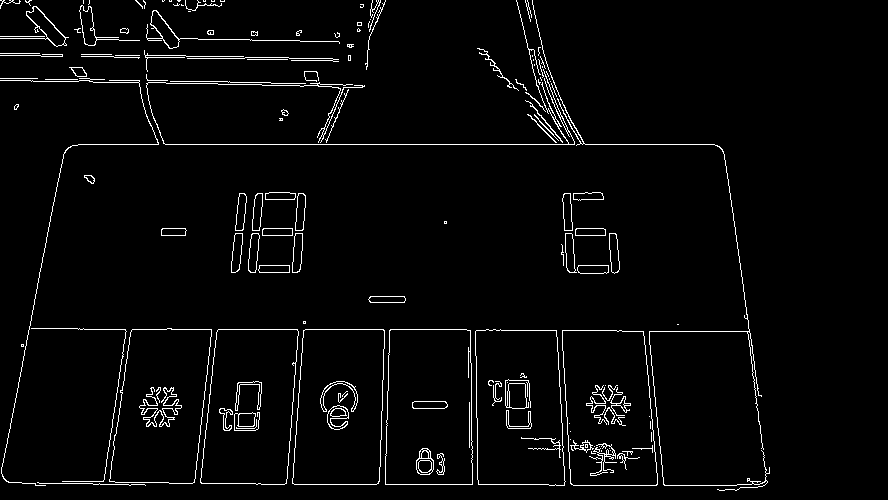

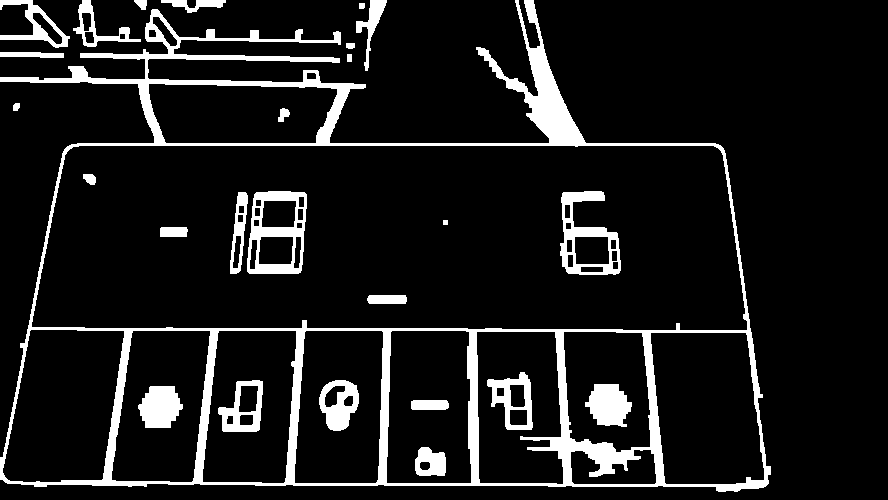

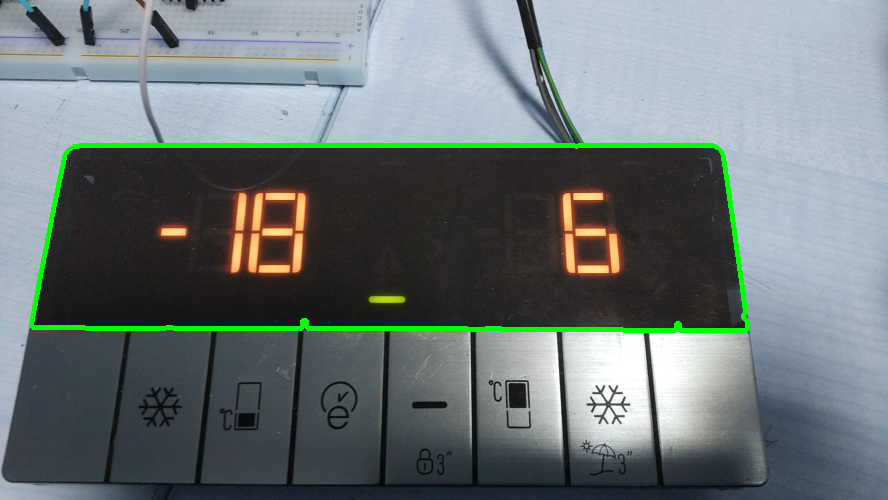

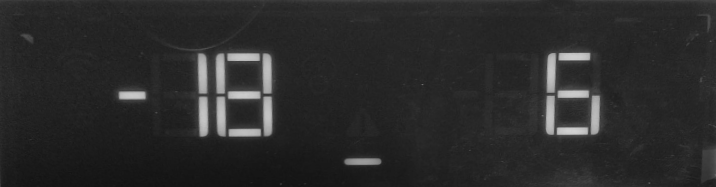

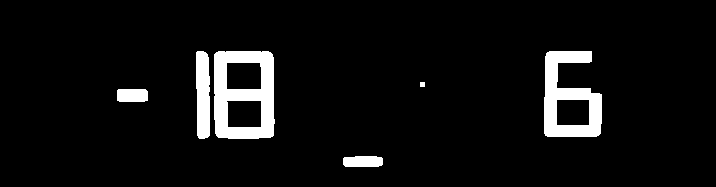

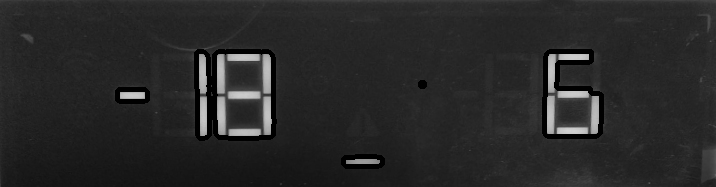

[1, 8, 6]


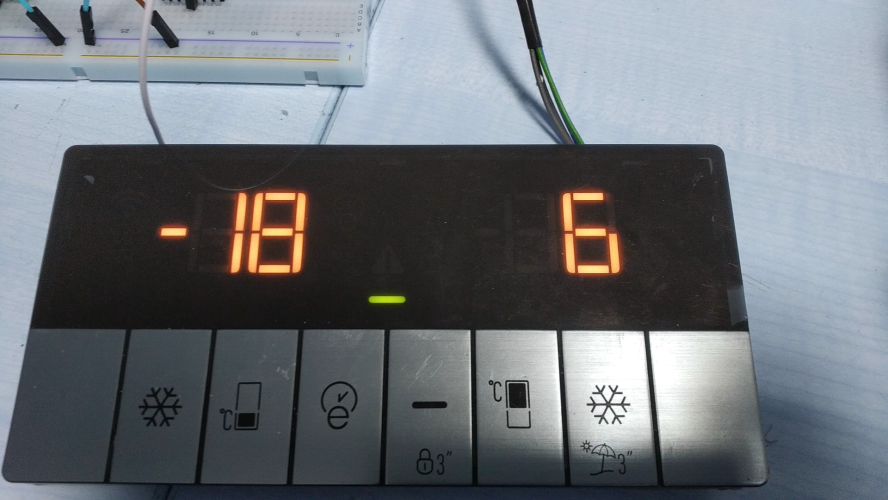

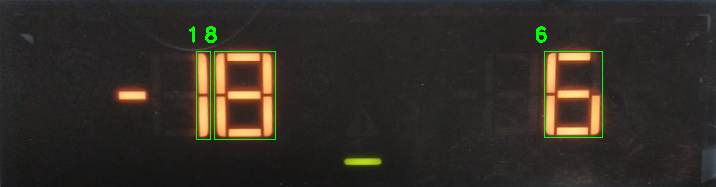

In [ ]:
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 0, 1): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}


# load the example image
displayim = r"/content/ex2.jpeg"
image = cv2.imread(displayim)

# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)[1]
edged = cv2.Canny(gray, 50, 200, 3)
display(PIL.Image.fromarray(edged))
dilate = cv2.dilate(edged, None, iterations=3)
erode = cv2.erode(dilate, None, iterations=2)


display(PIL.Image.fromarray(erode))

# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None

# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if the contour has four vertices, then we have found
	# the thermostat display
	if len(approx) == 4:
		displayCnt = approx
		break

copy_image = image.copy()
cv2.drawContours(copy_image, cnts, 1, (0,255,0), 3)
display(PIL.Image.fromarray(copy_image))

peri = cv2.arcLength(cnts[1], True)
approx = cv2.approxPolyDP(cnts[1], 0.02 * peri, True)
displayCnt = approx

warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))
display(PIL.Image.fromarray(warped))

thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
dilate = cv2.dilate(thresh, None, iterations=2)
erode = cv2.erode(dilate, None, iterations=0)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(erode, cv2.MORPH_OPEN, kernel)
display(PIL.Image.fromarray(thresh))

# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cv2.drawContours(warped, cnts, -1, (0,255,0), 3)
display(PIL.Image.fromarray(warped))
digitCnts = []
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# if the contour is sufficiently large, it must be a digit
	if w >= 10 and (h >= 40):
	    digitCnts.append(c)

# sort the contours from left-to-right, then initialize the
# actual digits themselves
digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
digits = []

# loop over each of the digits
for c in digitCnts:
	# extract the digit ROI
	(x, y, w, h) = cv2.boundingRect(c)
	roi = thresh[y:y + h, x:x + w]
	# compute the width and height of each of the 7 segments
	# we are going to examine
	(roiH, roiW) = roi.shape
	(dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
	dHC = int(roiH * 0.05)
	# define the set of 7 segments
	segments = [
		((0, 0), (w, dH)),	# top
		((0, 0), (dW, h // 2)),	# top-left
		((w - dW, 0), (w, h // 2)),	# top-right
		((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
		((0, h // 2), (dW, h)),	# bottom-left
		((w - dW, h // 2), (w, h)),	# bottom-right
		((0, h - dH), (w, h))	# bottom
	]
	on = [0] * len(segments)

	# loop over the segments
	for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
		# extract the segment ROI, count the total number of
		# thresholded pixels in the segment, and then compute
		# the area of the segment
		segROI = roi[yA:yB, xA:xB]
		total = cv2.countNonZero(segROI)
		area = (xB - xA) * (yB - yA)
		# if the total number of non-zero pixels is greater than
		# 50% of the area, mark the segment as "on"
		if float(area) != 0:
		    if total / float(area) > 0.5:
		        on[i]= 1
    
	if w < 20 and (h >= 40):
	    digit = 1
	else:
		digit = DIGITS_LOOKUP[tuple(on)]

	digits.append(digit)
	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
	cv2.putText(output, str(digit), (x - 10, y - 10),
	cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

print(digits)
display(PIL.Image.fromarray(image))
display(PIL.Image.fromarray(output))
